수정일: 2025.09.02

# HW2: Iris Classification

이번 과제에서는 neural network을 이용해 잘 알려져 있는 Iris(붓꽃) 데이터를 분류해 보겠다. 데이터셋에는 3개의 클래스로 구분된 150개(3 x 150)의 example이 포함되어 있으며, 각 클래스는 붓꽃 유형을 나타낸다.

이번 과제부터는 알고리즘을 밑바닦부터 직접 구현하지 않고, [PyTorch](https://pytorch.org/)를 이용할 것이다. 아래 나오는 내용들을 잘 읽어보고 지시에 따라 코드를 완성해 보자.

우선 필요한 모듈을 불러오고, 필요한 셋팅을 한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import urllib # 데이터셋을 다운로드 받기 위해 필요

import torch # PyTorch
from torch import nn # PyTorch 레이어

## 데이터
아래 코드를 실행시키면, 과제에 필요한 데이터를 불러온다. 그러나 이를 위해 [scikit-learn](https://scikit-learn.org/)이라는 라이브러리를 이용할 것이다. scikit-learn은 기계학습에 필요한 다양한 기능들을 제공한다. scikit-learn을 이용하면 데이터를 쉽게 불러올 수 있고, 가공할 수 있다. 이 때, 데이터 X와 Y는 NumPy 배열이다.

X의 모양을 보면 (데이터 개수, feature 수)로 표현된 것을 볼 수 있다. 수업시간에는 X의 모양을 (feature 수, 데이터 개수)로 나타냈는데, PyTorch에서는 (데이터 개수, feature 수)로 타나낸다. 즉, 행과 열이 바뀌어 있다. 따라서 구현 시에 이를 고려해야 한다.

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
Y = iris.target
m, n = X.shape

classes = iris.target_names
K = len(classes)

print("X의 크기:", X.shape)
print("Y의 크기:", Y.shape)
print("데이터 개수:", m)
print("Feature 수:", n)
print("분류 개수:", K)

X의 크기: (150, 4)
Y의 크기: (150,)
데이터 개수: 150
Feature 수: 4
분류 개수: 3


불러온 데이터를 확인하기 위해 일부 데이터를 출력한다. 데이터를 불러올 때, X에는 입력 데이터가 들어있고, Y에는 각 example에 해당하는 출력 데이터가 들어있다.

X 데이터의 각 열(column)은 꽃받침 길이(Sepal Length, cm), 꽃받침 너비(Sepal Width, cm), 꽃잎 길이(Petal Length, cm), 꽃잎 너비(Petal Width, cm)를 의미하고, Y 데이터는 해당 example의 품종(0: Setosa, 1: Versicolor, 2: Virginica)을 나타낸다. 따라서, 4개의 길이 또는 폭이 주어졌을 때, 붓꽃의 품종을 예측해야 한다.
<img src="https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png" />
참조: [https://www.datacamp.com/tutorial/machine-learning-in-r](https://www.datacamp.com/tutorial/machine-learning-in-r)

In [3]:
for i in np.random.randint(0, Y.size, size=5):
  print(X[i], classes[Y[i]])

[5.9 3.2 4.8 1.8] versicolor
[6.3 3.3 6.  2.5] virginica
[5.1 3.3 1.7 0.5] setosa
[5.1 3.4 1.5 0.2] setosa
[6.8 3.  5.5 2.1] virginica


불러온 데이터를 그래프로 출력한다.

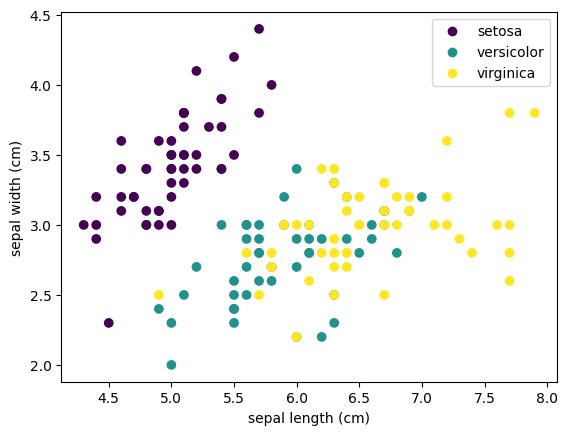

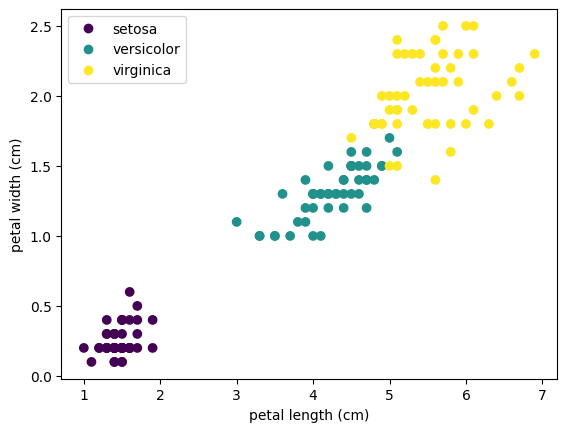

In [4]:
def plot_graph(x1, x2, y, label1, label2):
  _, ax = plt.subplots()
  scatter = ax.scatter(x1, x2, marker='o', c=y)

  ax.set_xlabel(label1)
  ax.set_ylabel(label2)
  ax.legend(scatter.legend_elements()[0], classes)

plot_graph(X[:,0], X[:,1], Y, "sepal length (cm)", "sepal width (cm)")
plt.show()

plot_graph(X[:,2], X[:,3], Y, "petal length (cm)", "petal width (cm)")
plt.show()

## 텐서(tensor)
텐서는 행렬과 유사한 데이터 구조로, 기계학습에서 데이터를 표현하기 위해 사용된다. 텐서는 또한 NumPy의 배열과도 유사하므로, 기계학습에서는 이 둘을 섞어 사용하며, 필요시 서로 변환하기도 한다. 그러나, PyTorch에서 최적화 기능을 이용하기 위해서는 궁극적으로는 텐서 형태로 데이터를 표현해야 하며, 이렇게 해야 자동으로 미분을 수행할 수 있다.

PyTorch에서 텐서를 사용하는 방법에 대해서는 [여기](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)를 참고한다.

이번 과제에서는 PyTorch를 이용하기 위해서는, NumPy 배열로 표현된 X와 Y를 텐서로 변환해야 한다. 이는 다음과 같이 하면 된다.

In [5]:
from torch.utils.data import TensorDataset

X = torch.FloatTensor(X) # 실수형
Y = torch.LongTensor(Y) # 정수형

print(X.shape)
print(Y.shape)

torch.Size([150, 4])
torch.Size([150])


학습할 때는 출력층을 one-hot encoding으로 표현하는 것이 더 잘 학습된다. 따라서, Y를 one-hot encoding으로 변환한다.

In [6]:
Y_one_hot = torch.zeros(m, K)
for i in range(Y.shape[0]):
  Y_one_hot[i, Y[i]] = 1

다음은 one-hot encoding으로 표현한 데이터 일부를 보여준다. 참고로, 텐서를 NumPy 배열로 변환할 때는 **numpy**()를 호출하면 되고, 스칼라 값으로 변환할 때는 **item**()을 호출하면 된다.

In [7]:
for i in np.random.randint(0, m, size=5):
  print("Y=", Y[i].item(), ", One-hot:", Y_one_hot[i].numpy())

Y= 2 , One-hot: [0. 0. 1.]
Y= 2 , One-hot: [0. 0. 1.]
Y= 0 , One-hot: [1. 0. 0.]
Y= 0 , One-hot: [1. 0. 0.]
Y= 1 , One-hot: [0. 1. 0.]


## 모델 생성
PyTorch에서 neural network 모델을 정의하기 위해서는 [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)에서 상속받은 클래스를 정의해야 한다. 그리고 **\_\_init\_\_()** 함수 안에 네트워크의 레이어들을 정의하고, **forward()** 함수 안에서 정의한 레이어들을 연결해 준다.

PyTorch에서는 neural network를 레이어 단위로 정의한다. 각 레이어는 노드들의 가중치(weights)와 바이어스(biases)를 가지는데, PyTorch에서 [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)로 정의한다. 이 때, 첫 번째 인자 **in_features**는 입력 노드의 개수, 두 번째 인자 **out_features**는 출력 노드의 개수를 나타낸다.

각 레이어의 출력은 다시 활성화 함수(activation function)로 연결되는데, 이번 과제에서는 **ReLU** 함수를 사용한다. PyTorch에서는 [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)를 사용한다.

마지막 레이어인 출력층에는 ReLU 함수 대신 **softmax** 함수를 사용하는데, PyTorch에서는 [nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)를사용한다.

이번 과제에서는 은닉층 2개, 출력층 1개를 정의하며, 첫 번째와 두 번째 은닉층의 노드 개수를 적절히 정의한다. 첫 번째 은닉층의 입력은 입력 데이터와 연결되므로 feature의 개수만큼 필요하다. 출력층의 출력은 붓꽃을 분류해야 하므로, 분류할 개수만큼 필요하다. (몇 개의 입력 노드와 출력 노드가 필요한지 생각해 보시오.)

추가적으로 PyTorch에서 모델 생성하는 방법을 공부하려면 [여기](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)를 참고한다.

**지시: Neural network 모델(IrisModel)을 정의할 수 있게 아래 코드를 완성한다.**

In [8]:
class IrisModel(nn.Module): # nn.Module을 상속받은 클래스를 정의. 이름을 IrisModel로 정의하였다.
  def __init__(self): # 이 안에 레이어들을 정의한다.
    super(IrisModel, self).__init__()

    ## nn.Linear를 이용해 첫 번째 은닉층을 정의하시오.
    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####
    self.hidden1 = nn.Linear(4, 10) # 입력 노드와 출력 노드의 개수
    #### 코드 종료 ####

    self.hidden1_activation = nn.ReLU() # ReLU 활성화 함수

    ## nn.Linear를 이용해 두 번째 은닉층을 정의하시오.
    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####
    self.hidden2 = nn.Linear(10, 10) # 입력 노드와 출력 노드의 개수
    #### 코드 종료 ####

    self.hidden2_activation = nn.ReLU() # ReLU 활성화 함수

    ## nn.Linear를 이용해 출력층을 정의하시오.
    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####
    self.output = nn.Linear(10, 3) # 입력 노드와 출력 노드의 개수
    #### 코드 종료 ####

    self.output_activation = nn.Softmax(dim=1) # Softmax 함수

  def forward(self, x): # 이 안에 레이어들을 연결해준다.
    x = self.hidden1(x) # x -> layer1 -> x
    x = self.hidden1_activation(x) # x -> layer2 -> x
    x = self.hidden2(x) # x -> layer3 -> x
    x = self.hidden2_activation(x) # x -> layer4 -> x
    x = self.output(x) # x -> layer5 -> x
    x = self.output_activation(x) # x -> layer6 -> x

    return x

위에서 정의한 IrisModel를 생성해 model 변수에 저장한다. 아무 문제가 없다면 아래 코드 실행 시 "성공!!!"이라고 출력되어야 한다.

In [9]:
model = IrisModel()

random_data = torch.rand((2, n))
result = model(random_data)

assert result.shape == (2, K)
print("성공!!!")

성공!!!


아래 코드는 모델에서 정의한 parameter(weight + bias)들의 값을 출력한다. Neural network에서는 학습 시, parameter의 초기값을 0이 아닌, 작은 실수 값으로 랜덤하게 설정해야 한다. 이는 PyTorch가 자동으로 해준다.

In [10]:
for parameter in model.parameters():
  print(parameter)

Parameter containing:
tensor([[-0.0441, -0.2869,  0.4051,  0.0737],
        [ 0.0717, -0.2255,  0.1400, -0.0619],
        [ 0.3079, -0.1704, -0.3834, -0.0220],
        [-0.2632,  0.3751, -0.3829,  0.1154],
        [ 0.4394,  0.0014, -0.1667,  0.2554],
        [ 0.3636, -0.3924, -0.0338, -0.4633],
        [ 0.4555, -0.1032,  0.4512,  0.1318],
        [-0.2203,  0.1826,  0.3624, -0.1336],
        [ 0.1461,  0.3221, -0.0200, -0.2218],
        [-0.0987, -0.0633, -0.2086, -0.5000]], requires_grad=True)
Parameter containing:
tensor([ 0.0609, -0.4559,  0.4953, -0.4662, -0.0395,  0.4551, -0.1953,  0.0545,
         0.2616,  0.1164], requires_grad=True)
Parameter containing:
tensor([[ 0.0814, -0.0303, -0.2029, -0.2169,  0.0766,  0.1910,  0.0441,  0.1408,
          0.2877,  0.0057],
        [-0.1180,  0.0674,  0.2322,  0.0532,  0.0497,  0.1897,  0.0777, -0.0311,
         -0.1045,  0.2709],
        [-0.2283, -0.2429, -0.0006,  0.1846, -0.0450,  0.0377,  0.2306, -0.3052,
         -0.2615, -0.2801],

## 학습
### Hyperparameters

학습을 위해 다음과 같이 하이퍼파라미터를 설정한다.
- iterations = 200
- learning_rate = 0.01

In [11]:
# Hyperparameter를 설정한다.
# 사용자가 변경할 수 있다.
iterations = 200 # 반복 회수
learning_rate = 0.01 # Learning rate

### Loss function

모델을 학습하기 위해서 loss function을 생성한다. PyTorch는 다양한 [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)을 제공한다. 이번 과제에서는 cross entropy loss를 사용할 것인데, 이는 PyTorch에서 제공하지 않기 때문에 직접 구현해야 한다. (PyTorch가 제공하는 함수는 softmax와 cross entropy를 함께 계산한다.) Cross entropy loss는 다음과 같이 정의된다.

$L=\cfrac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[-y^{(i)}log(f_{W}(x^{(i)})_k+\epsilon)]$

여기서 $\epsilon$은 매우 작은 수로, log 안에 0이 들어오는 것을 방지하기 위한 장치이다.

In [12]:
def cross_entropy(prediction, target):
  '''
  prediction과 target에 대해 cross entropy loss를 계산하여 반환하는 함수

  매개변수:
    prediction: 예측한 출력값, torch.Tensor 2차원 배열
    target: 참값, torch.Tensor 2차원 배열

  반환:
    loss 값, 스칼라
  '''
  epsilon = 1e-9
  loss = -torch.sum(target * torch.log(prediction + epsilon))
  return loss

target = torch.tensor([[1.0, 0.0, 0.0], [1.0, 0.0, 0.0]])
prediction = torch.tensor([[0.7, 0.2, 0.1], [0.1, 0.3, 0.6]])

loss = cross_entropy(prediction, target)
print(loss.numpy()) # 2.65926 정도가 출력되어야 한다.

2.65926


### Optimization algorithm

다음에는 최적화 알고리즘을 선택한다. 수업시간에 배운 backpropagation 알고리즘을 사용할 것인데, 최근에는 이를 개선한 다양한 방법들이 많이 개발되었다. PyTorch도 다양한 [optimizer](https://pytorch.org/docs/stable/optim.html)를 제공한다. 우리는 그 중에서 **Adam** 방법을 사용할 것이며, 최적화 알고리즘에 대해서는 나중에 수업 시간에 다시 다룰 것이다. 이번 과제에서는 아무 이유없이 Adam을 사용하도록 한다. PyTorch에서 Adam은 [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)으로 정의한다. 그리고 다음과 같이 생성한다.

여기서, **model.parameters**()는 우리가 정의한 모델의 parameter들(가중치들)을 나타내며, 임의의 실수로 초기화 되어 있다. lr은 **learning rate**를 나타낸다.

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 최적화 루프

Gradient descent 방법에서와 같이, 가중치를 변경하는 작업을 반복한다. 이전 과제에서는 루프 안에서 parameter의 미분값을 계산하고, parameter에 반영을 해주었다. Neural network에서는 backpropagation 알고리즘을 이용하는데, 전반적인 흐름은 동일하며, 정리하면 다음과 같다.

* Forward propagation 수행
* Backpropagation 수행
* 가중치 업데이트

이는 PyTorch를 이용해 다음과 같은 패턴으로 구현한다.

In [14]:
# 학습 상황을 저장하기 위한 변수
history = np.zeros((iterations, 2)) # Loss와 accuracy를 저장

for iter in range(iterations):
  print("Iteration ", iter+1)

  iteration_loss = 0 # 매 iteration의 loss를 계산하여 저장

  optimizer.zero_grad() # Gradient를 0으로 초기화
  Y_pred = model(X) # 모델을 이용해 forward propagation 수행
  loss = cross_entropy(Y_pred, Y_one_hot) # 모델의 출력인 Y_pred(예측값)과 학습 데이터셋의 Y_one_hot(참값)을 이용해 loss 계산
  loss.backward() # Backpropagation 수행
  optimizer.step() # 가중치 업데이트

  iteration_loss = loss.item() # 현재 loss 계산
  average_loss = iteration_loss / m

  prediction = Y_pred.argmax(1) # 예측한 결과. 가장 큰 값을 가지는 인덱스를 가져온다.
  correct = (prediction == Y) # 참값과 예측이 맞는지 확인.type(torch.float).sum().item()
  accuracy = correct.type(torch.float).sum().item() / m * 100 # 맞는 개수를 백분율로 환산

  history[iter, 0] = average_loss
  history[iter, 1] = accuracy

  print("Accuracy:", accuracy, "Average loss:", average_loss)

Iteration  1
Accuracy: 33.33333333333333 Average loss: 1.2224129231770833
Iteration  2
Accuracy: 33.33333333333333 Average loss: 1.1578016153971353
Iteration  3
Accuracy: 33.33333333333333 Average loss: 1.1203111775716146
Iteration  4
Accuracy: 33.33333333333333 Average loss: 1.09591552734375
Iteration  5
Accuracy: 48.0 Average loss: 1.0745986938476562
Iteration  6
Accuracy: 62.66666666666667 Average loss: 1.0521016438802084
Iteration  7
Accuracy: 62.66666666666667 Average loss: 1.0286485799153646
Iteration  8
Accuracy: 50.66666666666667 Average loss: 1.005826212565104
Iteration  9
Accuracy: 40.666666666666664 Average loss: 0.9811715698242187
Iteration  10
Accuracy: 48.66666666666667 Average loss: 0.9535780843098959
Iteration  11
Accuracy: 66.66666666666666 Average loss: 0.9225670369466146
Iteration  12
Accuracy: 67.33333333333333 Average loss: 0.889049072265625
Iteration  13
Accuracy: 66.66666666666666 Average loss: 0.8530649820963542
Iteration  14
Accuracy: 66.66666666666666 Average 

아래 코드는 매 iteration 마다 loss와 accuracy가 변하는 과정을 그래프로 보여준다. Iteration이 진행됨에 따라서 loss가 감소해야 한다.

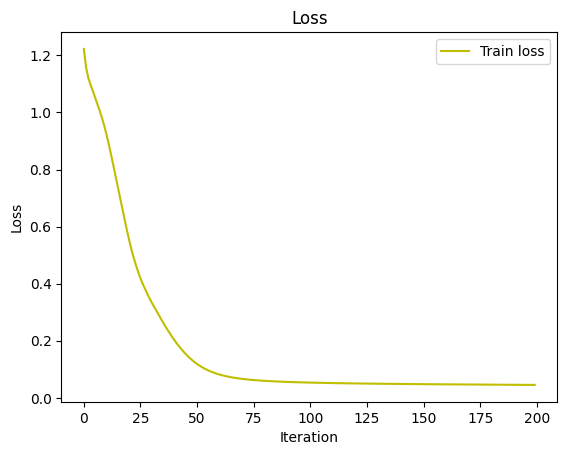

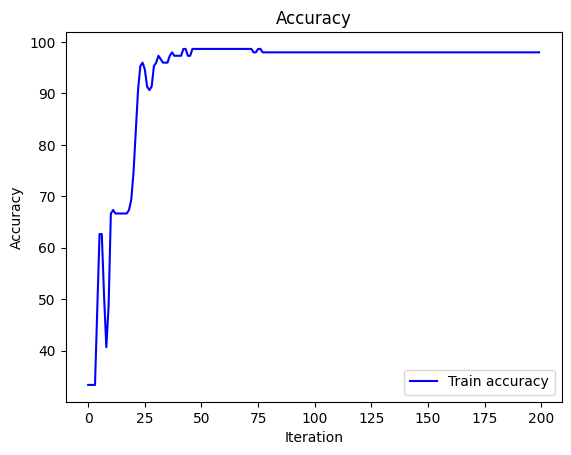

In [15]:
def plot_history(history):
  _, ax = plt.subplots()
  ax.plot(history[:,0], 'y', label='Train loss')
  ax.set_title('Loss')
  ax.set_xlabel('Iteration')
  ax.set_ylabel('Loss')
  ax.legend()
  plt.show()

  _, ax = plt.subplots()
  ax.plot(history[:,1], 'b', label='Train accuracy')
  ax.set_title('Accuracy')
  ax.set_xlabel('Iteration')
  ax.set_ylabel('Accuracy')
  ax.legend()
  plt.show()

plot_history(history)
plt.show()

이번 과제에서 사용한 모델은 데이터의 갯수에 비해 반복 횟수가 많다. 이는 모델의 구조를 개선해서 정확도를 높일 수 있다. 이에 대해서는 앞으로 공부할 것이다.

이번 과제는 여기까지 입니다. 수고하셨습니다.